# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [2]:
!pip install labelme opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [4]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [7]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [8]:
!labelme

2022-12-13 12:43:35.047 python[83316:1271307] +[CATransaction synchronize] called within transaction
2022-12-13 12:43:35.181 python[83316:1271307] +[CATransaction synchronize] called within transaction
2022-12-13 12:44:53.213 python[83316:1271307] +[CATransaction synchronize] called within transaction
2022-12-13 12:44:53.331 python[83316:1271307] +[CATransaction synchronize] called within transaction


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

tf.__version__

'2.7.0'

### 2.2 Limit GPU Memory Growth

In [10]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [11]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2.3 Load Image into TF Data Pipeline

In [12]:
images = tf.data.Dataset.list_files('data/images/*.jpg')

In [13]:
images.as_numpy_iterator().next()

b'data/images/90765c50-7ab5-11ed-ad20-823843e22b40.jpg'

In [14]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [15]:
images = images.map(load_image)

In [16]:
images.as_numpy_iterator().next()

array([[[176, 164, 138],
        [178, 166, 140],
        [178, 166, 140],
        ...,
        [159, 148, 116],
        [161, 148, 116],
        [163, 150, 118]],

       [[175, 163, 137],
        [176, 164, 138],
        [173, 161, 135],
        ...,
        [160, 149, 117],
        [164, 151, 119],
        [165, 152, 120]],

       [[175, 161, 134],
        [179, 165, 138],
        [179, 165, 138],
        ...,
        [163, 152, 120],
        [167, 154, 122],
        [168, 155, 123]],

       ...,

       [[169, 151, 129],
        [158, 140, 118],
        [154, 136, 114],
        ...,
        [229, 211, 103],
        [229, 211, 103],
        [229, 211, 103]],

       [[156, 135, 114],
        [155, 134, 113],
        [159, 138, 117],
        ...,
        [228, 210, 102],
        [229, 211, 103],
        [229, 211, 103]],

       [[148, 127, 106],
        [154, 133, 112],
        [161, 140, 119],
        ...,
        [228, 210, 102],
        [228, 210, 102],
        [229, 211, 103]]

In [17]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

In [18]:
image_generator = images.batch(4).as_numpy_iterator()

In [21]:
plot_images = image_generator.next()

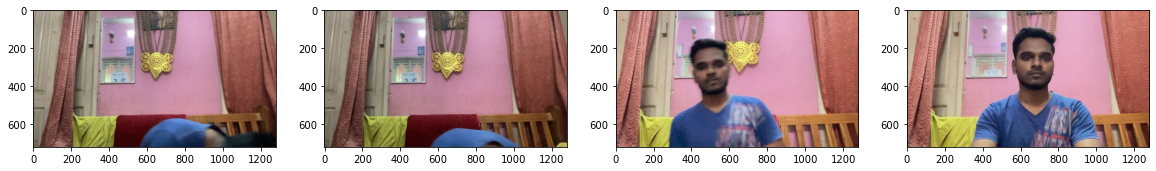

In [22]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [23]:
90*.7 # 63 to train

62.99999999999999

In [24]:
90*.15 # 14 and 13 to test and val

13.5

### 3.2 Move the Matching Labels

In [25]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [26]:
import albumentations as alb

In [27]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [28]:
img = cv2.imread(os.path.join('data','train', 'images','6362c8e8-7ab5-11ed-ad20-823843e22b40.jpg'))

In [29]:
with open(os.path.join('data', 'train', 'labels', '6362c8e8-7ab5-11ed-ad20-823843e22b40.json'), 'r') as f:
    label = json.load(f)

In [30]:
label['shapes'][0]['points']

[[478.57142857142856, 28.095238095238088],
 [793.8095238095239, 444.2857142857143]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [31]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [32]:
coords

[478.57142857142856, 28.095238095238088, 793.8095238095239, 444.2857142857143]

In [33]:
coords =  list(np.divide(coords, [1280,720,1280,720]))

In [34]:
coords

[0.37388392857142855,
 0.03902116402116401,
 0.6201636904761905,
 0.6170634920634921]

### 4.4 Apply Augmentations and View Results

In [35]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [36]:
augmented['bboxes'][0][2:]

(0.24984126984126986, 0.7717460317460318)

In [37]:
augmented['bboxes']

[(0.0, 0.0, 0.24984126984126986, 0.7717460317460318)]

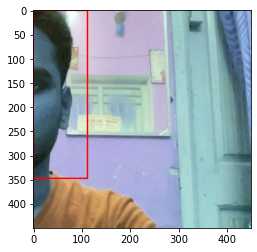

In [38]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [41]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            
            try:
                coords[0] = label['shapes'][0]['points'][0][0]
                coords[1] = label['shapes'][0]['points'][0][1]
                coords[2] = label['shapes'][0]['points'][1][0]
                coords[3] = label['shapes'][0]['points'][1][1]
                coords = list(np.divide(coords, [1280,720,1280,720]))
            
            except Exception as e:
                print(e)

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type
image must be numpy array type
image must be numpy array type


### 5.2 Load Augmented Images to Tensorflow Dataset

In [42]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [43]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [44]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [45]:
train_images.as_numpy_iterator().next()

array([[[3.9215689e-03, 7.8431377e-03, 0.0000000e+00],
        [0.0000000e+00, 3.9215689e-03, 0.0000000e+00],
        [4.4117649e-03, 8.3333338e-03, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[3.9215689e-03, 3.9215689e-03, 0.0000000e+00],
        [6.1274513e-05, 6.1274513e-05, 0.0000000e+00],
        [4.2892157e-04, 4.2892157e-04, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[3.9215689e-03, 3.9215689e-03, 0.0000000e+00],
        [4.2892157e-04, 4.2892157e-04, 0.0000000e+00],
        [3.9215689e-03, 3.9215689e-03, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [46]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [47]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [48]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [49]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [52]:
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [53]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

### 7.2 Create Final Datasets (Images/Labels)

In [54]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [55]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [56]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [57]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.     , 0.     , 0.3088 , 0.4326 ],
        [0.     , 0.1542 , 0.381  , 1.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.2861 , 0.1495 , 0.9316 , 0.918  ],
        [0.347  , 0.2969 , 0.7617 , 0.809  ],
        [0.     , 0.     , 0.01576, 0.3596 ],
        [0.     , 0.     , 0.     , 0.     ]], dtype=float16))

### 7.3 View Images and Annotations

In [58]:
data_samples = train.as_numpy_iterator()

In [59]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


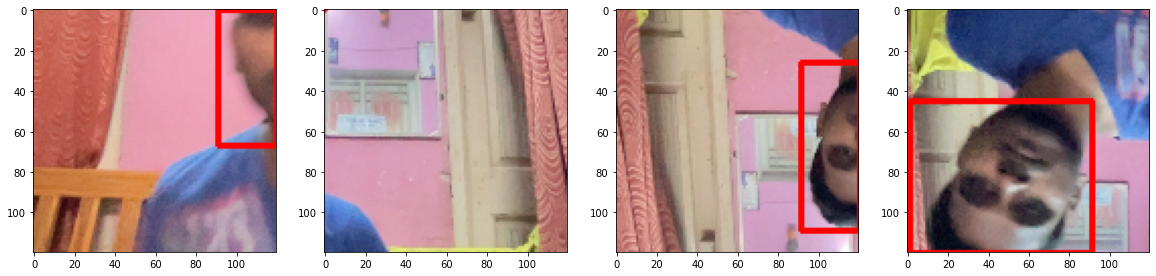

In [60]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [61]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [62]:
vgg = VGG16(include_top=False)

In [63]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [64]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [65]:
facetracker = build_model()

In [66]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [67]:
X, y = train.as_numpy_iterator().next()

In [68]:
X.shape

(8, 120, 120, 3)

In [69]:
classes, coords = facetracker.predict(X)

In [70]:
classes, coords

(array([[0.56527096],
        [0.6826364 ],
        [0.6058967 ],
        [0.6690436 ],
        [0.71075815],
        [0.6355335 ],
        [0.6175048 ],
        [0.7092049 ]], dtype=float32),
 array([[0.58521616, 0.5177009 , 0.30301636, 0.47298974],
        [0.6263266 , 0.52831435, 0.21804   , 0.45531753],
        [0.71130174, 0.56774807, 0.15946622, 0.48278236],
        [0.5541605 , 0.4989795 , 0.20785832, 0.46732903],
        [0.58185166, 0.48133025, 0.26605207, 0.47406983],
        [0.6698011 , 0.48204595, 0.25400403, 0.46663153],
        [0.6414272 , 0.52333575, 0.2755092 , 0.5036597 ],
        [0.72967035, 0.5025543 , 0.22134472, 0.37183237]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [71]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [72]:
lr_decay

0.0007047216349541929

In [74]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [75]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [76]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [77]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=8.259075>

In [78]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8927518>

In [79]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=8.259075>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [80]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [131]:
model = FaceTracker(facetracker)

In [132]:
model.compile(opt, classloss, regressloss, metrics=['accuracy'])

### 10.2 Train

In [133]:
logdir='logs'

In [134]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [137]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks = [tensorboard_callback])

Epoch 1/10
473/473 [==============================] - 86s 172ms/step - total_loss: 0.1867 - class_loss: 0.0615 - regress_loss: 0.1559 - val_total_loss: 0.0789 - val_class_loss: 0.0459 - val_regress_loss: 0.0560
Epoch 2/10
473/473 [==============================] - 85s 169ms/step - total_loss: 0.0884 - class_loss: 0.0284 - regress_loss: 0.0743 - val_total_loss: 0.0018 - val_class_loss: 0.0028 - val_regress_loss: 3.6485e-04
Epoch 3/10
473/473 [==============================] - 83s 166ms/step - total_loss: 0.0508 - class_loss: 0.0162 - regress_loss: 0.0427 - val_total_loss: 0.0575 - val_class_loss: 0.0019 - val_regress_loss: 0.0565
Epoch 4/10
473/473 [==============================] - 85s 171ms/step - total_loss: 0.0620 - class_loss: 0.0205 - regress_loss: 0.0518 - val_total_loss: 0.0048 - val_class_loss: 0.0035 - val_regress_loss: 0.0030
Epoch 5/10
473/473 [==============================] - 85s 170ms/step - total_loss: 0.0367 - class_loss: 0.0098 - regress_loss: 0.0318 - val_total_loss: 

### 10.3 Plot Performance

In [138]:
hist.history

{'total_loss': [0.06351808458566666,
  0.014816711656749249,
  0.007405225187540054,
  0.004804205149412155,
  0.0018948165234178305,
  0.0015096492134034634,
  0.0016993774333968759,
  0.002476621186360717,
  0.004914887249469757,
  0.0013539544306695461],
 'class_loss': [0.03197285532951355,
  0.011624371632933617,
  0.003792284522205591,
  2.514005063858349e-05,
  0.0014792346628382802,
  0.0006866311887279153,
  1.6112768435050384e-06,
  1.2972844160685781e-05,
  0.00229421048425138,
  5.422566391644068e-05],
 'regress_loss': [0.04753165692090988,
  0.00900452584028244,
  0.005509083159267902,
  0.00479163508862257,
  0.0011551992502063513,
  0.0011663336772471666,
  0.0016985718393698335,
  0.0024701347574591637,
  0.0037677818909287453,
  0.0013268416514620185],
 'val_total_loss': [0.07890447974205017,
  0.0017515197396278381,
  0.05747092515230179,
  0.004774521570652723,
  0.31068670749664307,
  0.0037219447549432516,
  0.07152046263217926,
  0.004026107490062714,
  0.772990763

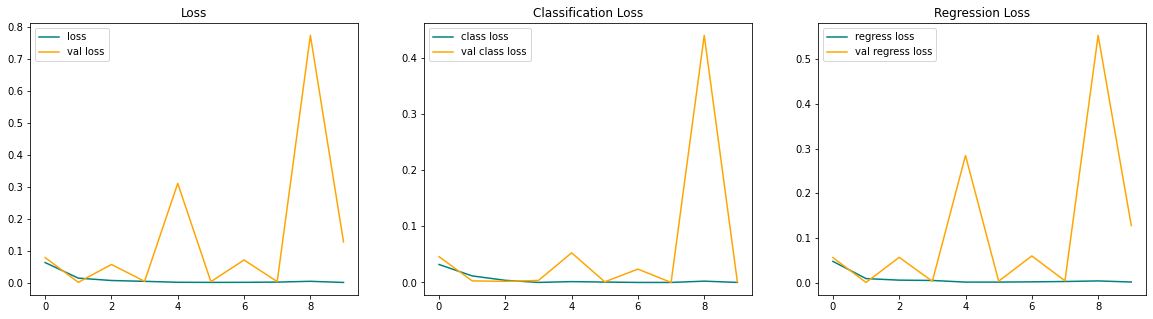

In [139]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [140]:
test_data = test.as_numpy_iterator()

In [141]:
test_sample = test_data.next()

In [142]:
yhat = facetracker.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


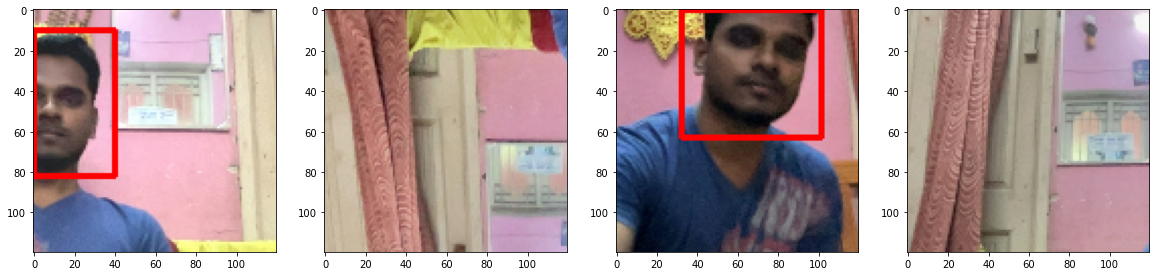

In [143]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [ ]:
import cv2
import tensorflow as tf

In [3]:
from tensorflow.keras.models import load_model

In [2]:
facetracker.save('facetracker.h5')

NameError: name 'facetracker' is not defined

In [4]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [5]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 